<a href="https://colab.research.google.com/github/harrison-webb/plant-classification/blob/main/plantClassificationColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm

TEST_SIZE = 0.1
BATCH_SIZE = 64
SEED = 42

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Move to project directory

In [ ]:
dir = "/content/drive/MyDrive/Colab Notebooks/plant-classification"
if os.getcwd() != dir:
    os.chdir(dir)
    print("directory changed to /plant-classification")

%pwd

directory changed to /plant-classification


'/content/drive/MyDrive/Colab Notebooks/plant-classification'

In [ ]:
path = "data/flowers/"
folders = glob.glob(path + "*")
print(folders)

['data/flowers/daisy', 'data/flowers/dandelion', 'data/flowers/rose', 'data/flowers/sunflower', 'data/flowers/tulip']


Creating a temporary transform, dataset, and dataloader in order to loop over the images to find the mean and standard deviation so that we can use those values in transforms.Normalize() later in our 'real' transform.

In [ ]:
tempTransform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor()
    ]
)
tempData = datasets.ImageFolder(path, transform=tempTransform)
tempDataLoader = DataLoader(tempData, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
def calculateMeanAndSD(loader):
    #referenced https://www.youtube.com/watch?v=y6IEcEBRZks
    #Var(X) = E[X^2] - (E[X])^2
    channels_sum, channels_sum_squared, num_batches = 0, 0, 0

    for data, _ in tqdm(loader):
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_sum_squared += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1

    mean = channels_sum / num_batches
    #use variance formula
    standard_deviation = ((channels_sum_squared / num_batches) - mean**2)**0.5

    print(mean, standard_deviation)
    return mean, standard_deviation

This is the actual transform we will be using on the data.

In [ ]:
#mean, sd = calculateMeanAndSD(tempDataLoader)
#hardcoded values if i dont want to recalculate
mean, sd = torch.tensor([0.4818, 0.4332, 0.3072]), torch.tensor([0.2938, 0.2638, 0.2882])
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(35),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=sd)
    ]
)

Now we can set up the dataset and dataloader we will be using, but we still need to segment into test and train data.

In [ ]:
flowerData = datasets.ImageFolder(path, transform=transform)
flowerDataLoader = DataLoader(flowerData, batch_size=BATCH_SIZE, shuffle=True)

Let's make sure the images are what we expect:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


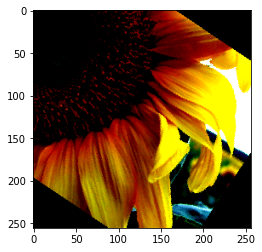

In [ ]:
inputs, classes = next(iter(flowerDataLoader))
plt.imshow(np.transpose(inputs[1].numpy(), (1,2,0))) # should de-normalize to fix weird colors

Splitting data into test and train sets:

In [ ]:
# https://stackoverflow.com/a/68338670
# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices, _, _ = train_test_split(
    range(len(flowerData)),
    flowerData.targets,
    stratify=flowerData.targets,
    test_size=TEST_SIZE,
    random_state=SEED
)

# generate subset based on indices
train_split = Subset(flowerData, train_indices)
test_split = Subset(flowerData, test_indices)

# create batches
train_batches = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
test_batches = DataLoader(test_split, batch_size=BATCH_SIZE, shuffle=True)

# set up dataloader dictionary for easier training
dataloaders = {"train": train_batches, "test": test_batches}
dataset_sizes = {"train": len(train_batches), "test": len(test_batches)}

At this point, we have processed the images, and split them into 'train_split' and 'test_split'. Now we're ready to train the model!
______

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=35):
    since = time.time()

    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}\n")

        for phase in ["train", "test"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_accuracy = running_corrects.double() / dataset_sizes[phase]

            # deep copy model if it beats the previous most accurate one
            if phase == "test" and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_weights = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60}m {time_elapsed % 60}s")
    print(f"Best accuracy: {best_accuracy:4f}")

    model.load_state_dict(best_model_weights)
    return model

In [ ]:
# Get model ready for training
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features

model.fc = nn.Linear(num_features, 5) # 5 output categories

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7)

In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler)

Epoch 0/34


Epoch 1/34


Epoch 2/34


Epoch 3/34


Epoch 4/34


Epoch 5/34


Epoch 6/34


Epoch 7/34


Epoch 8/34


Epoch 9/34


Epoch 10/34


Epoch 11/34


Epoch 12/34


Epoch 13/34


Epoch 14/34


Epoch 15/34


Epoch 16/34


Epoch 17/34


Epoch 18/34


Epoch 19/34


Epoch 20/34


Epoch 21/34


Epoch 22/34


Epoch 23/34


Epoch 24/34


Epoch 25/34


Epoch 26/34


Epoch 27/34


Epoch 28/34


Epoch 29/34


Epoch 30/34


Epoch 31/34


Epoch 32/34


Epoch 33/34


Epoch 34/34


Training complete in 44.0m 11.054197311401367s
Best accuracy: 58.571429


In [ ]:
torch.save(model.state_dict(), ".")

NameError: ignored

Resources used:  
- https://discuss.pytorch.org/t/simple-efficient-way-to-create-dataset/65178/3
- https://stackoverflow.com/questions/48818619/pytorch-how-do-the-means-and-stds-get-calculated-in-the-transfer-learning-tutor?rq=1
- https://www.youtube.com/watch?v=y6IEcEBRZks
- https://blog.jovian.ai/using-pytorch-to-classify-flowers-ce297310a412
- https://www.kaggle.com/code/devashishpandit/flowers-classification-with-pytorch
- https://medium.com/analytics-vidhya/creating-a-custom-dataset-and-dataloader-in-pytorch-76f210a1df5d
- https://developpaper.com/detailed-explanation-of-the-use-of-imagefolder-in-pytorch/
- Data: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
- https://www.kaggle.com/code/leifuer/intro-to-pytorch-loading-image-data/notebook
- https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets?rq=1
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
